In [2]:
import pandas as pd

apikey = ''
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=INTC&apikey={apikey}&outputsize=full&datatype=csv'

data = pd.read_csv(url)
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6047 entries, 0 to 6046
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  6047 non-null   object 
 1   open       6047 non-null   float64
 2   high       6047 non-null   float64
 3   low        6047 non-null   float64
 4   close      6047 non-null   float64
 5   volume     6047 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 283.6+ KB
None


,timestamp,open,high,low,close,volume
0,2023-11-10,38.24,38.990,38.2400,38.86,38871279
1,2023-11-09,38.05,38.515,37.7700,37.80,48955771
2,2023-11-08,38.85,38.890,37.7492,37.92,33483360
3,2023-11-07,38.24,38.900,37.9800,38.77,32052041
4,2023-11-06,38.02,38.200,37.8550,37.95,23877203


In [3]:
data_save = data.copy()

In [27]:
data = data_save.copy().sort_values(['timestamp'])

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# Графики цен открытия и закрытия

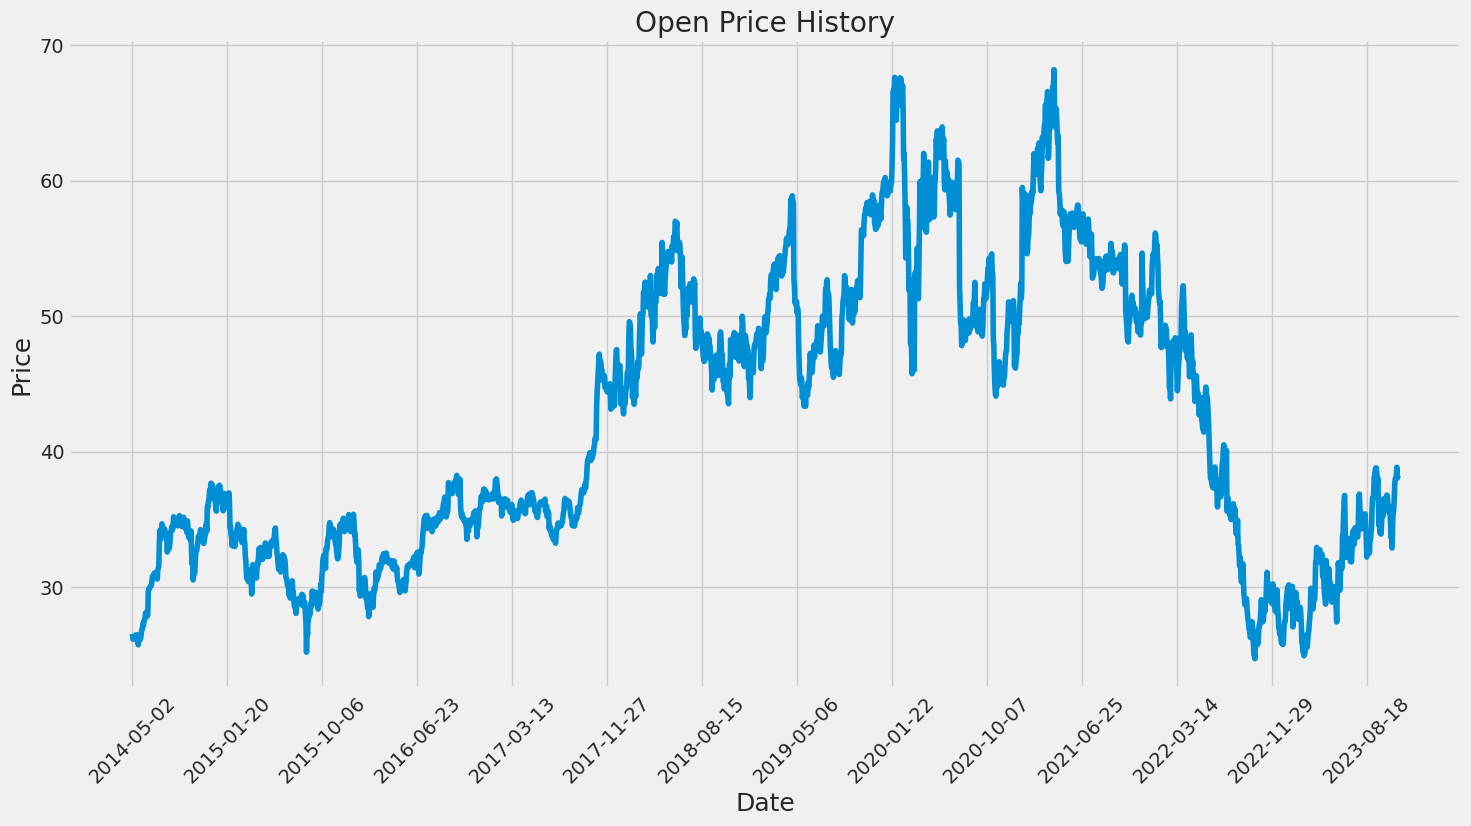

In [17]:
tmp = data.tail(2400).reset_index(drop=True)

plt.figure(figsize=(16,8))
g = sns.lineplot(data=tmp, x='timestamp', y='open')
g.set_xticks(tmp.timestamp[::180].index, labels=tmp.timestamp[::180])
g.tick_params(axis='x', rotation=45)
plt.title('Open Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

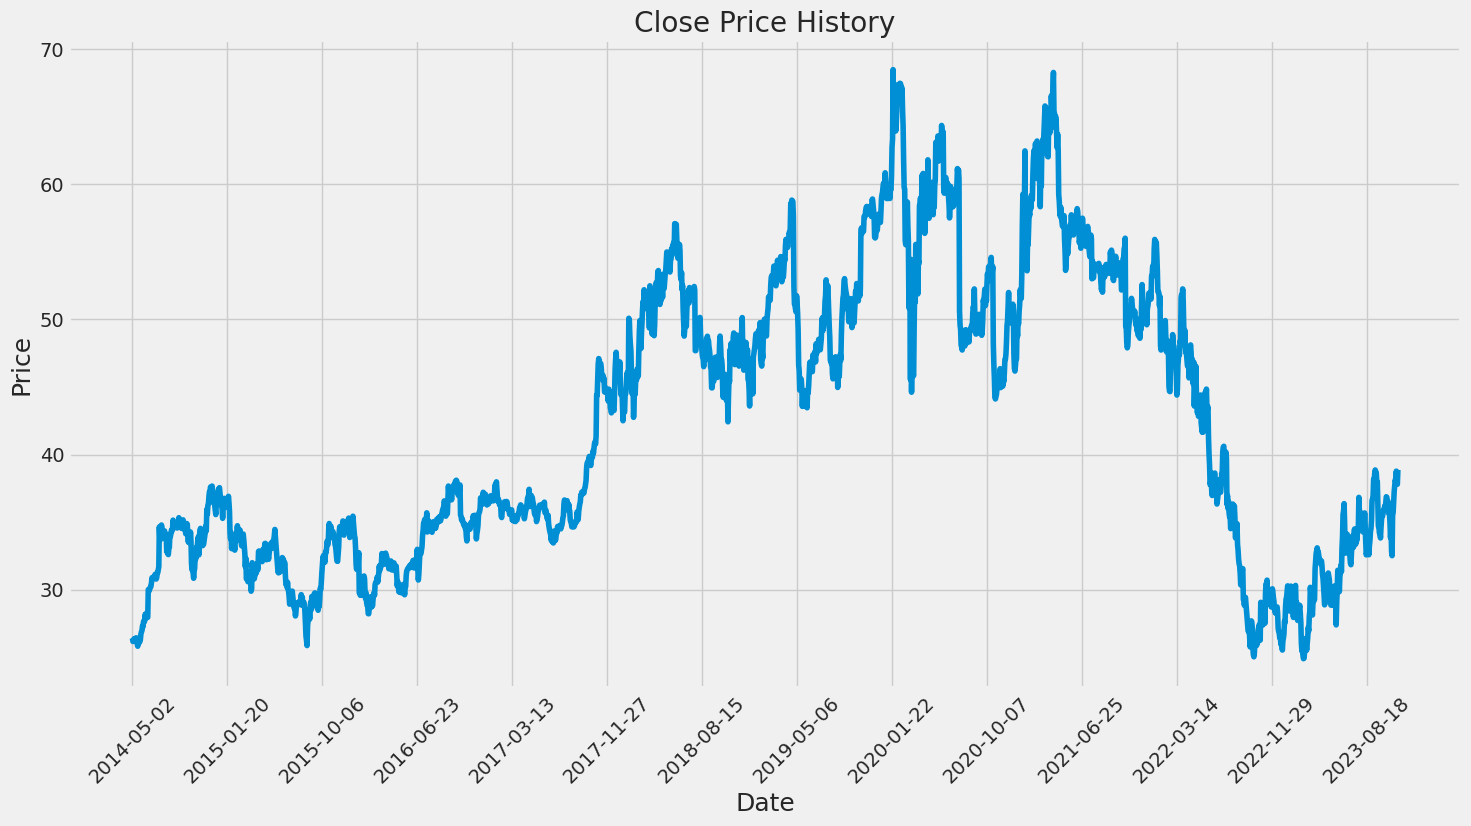

In [18]:
tmp = data.tail(2400).reset_index(drop=True)

plt.figure(figsize=(16,8))
g = sns.lineplot(data=tmp, x='timestamp', y='close')
g.set_xticks(tmp.timestamp[::180].index, labels=tmp.timestamp[::180])
g.tick_params(axis='x', rotation=45)
plt.title('Close Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

In [39]:
data = data_save.copy().sort_values(['timestamp'])
for sh in [1, 4, 20, 250]:
    for w in [2, 5, 20]:
        data[f'open_sh{sh}_w{w}'] = data.open.shift(sh).rolling(w).mean()

## Анализ лаговых фич

Рассмотрим корреляцию цен (open, close, low, high) с лаговыми фичами, построенными на цене open в зависимости от рассматриваемого периода.

### Период - 23 года

In [48]:
data.tail(6000).timestamp.min(), data.tail(6000).timestamp.max(),

('2000-01-07', '2023-11-10')

<Axes: >

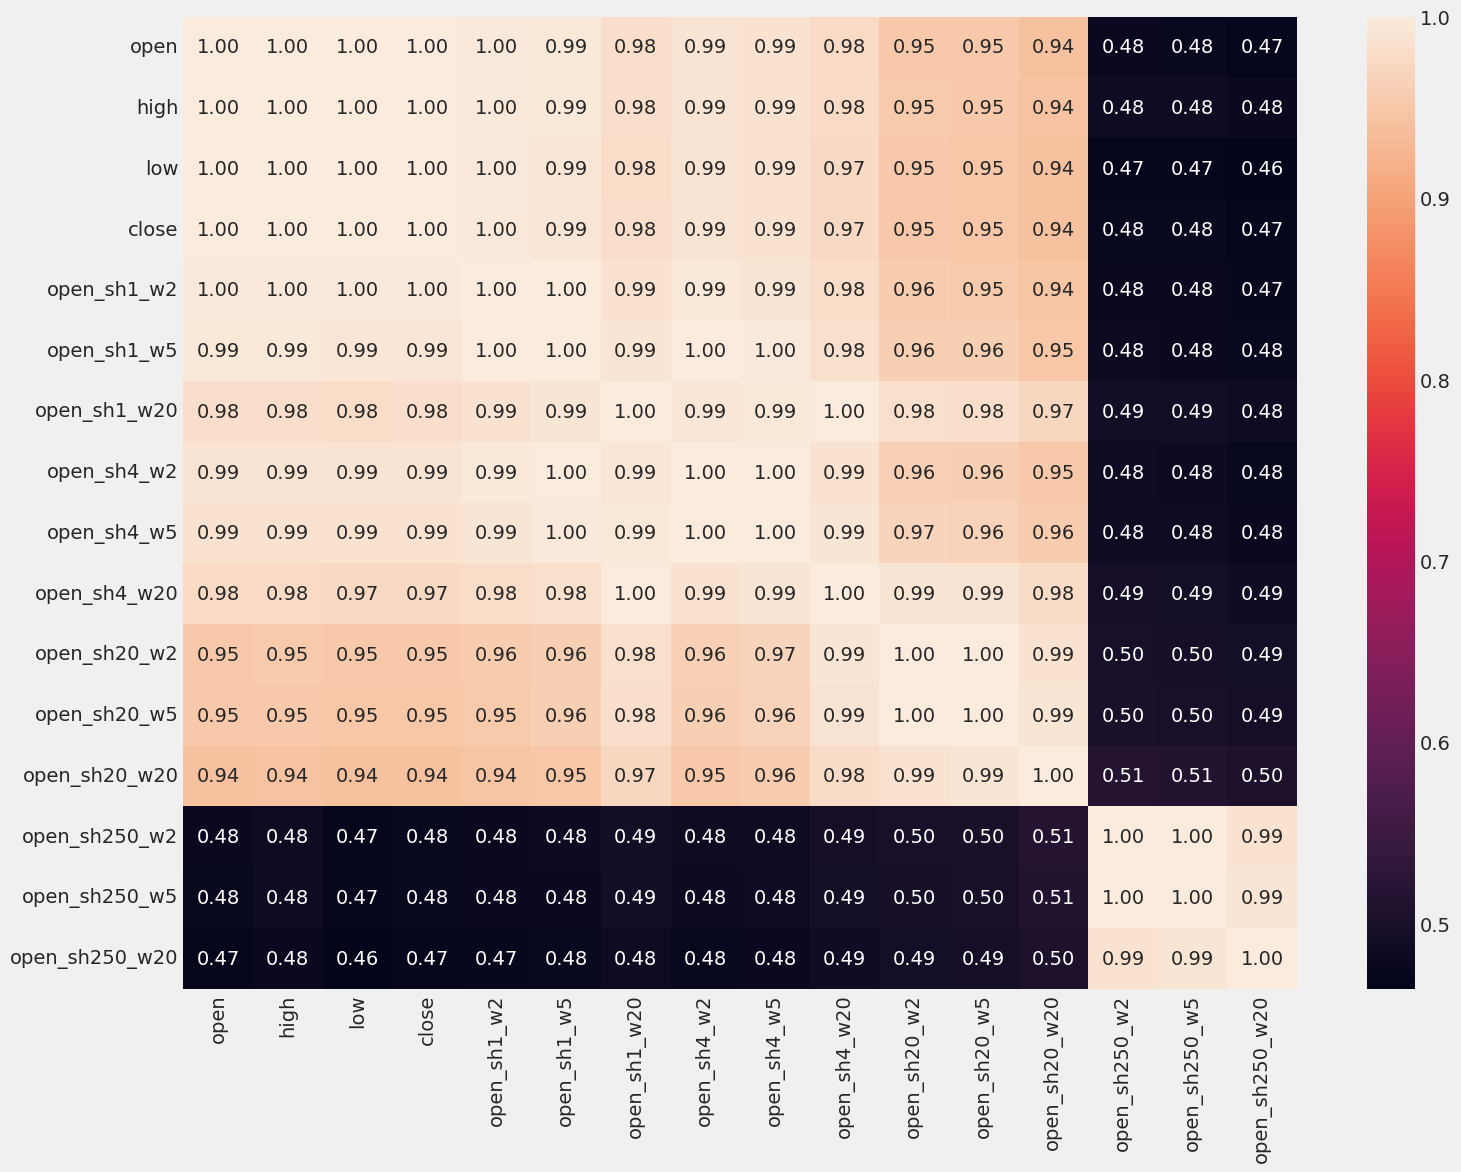

In [42]:
f, ax = plt.subplots(figsize=(16, 12))
corr = data.drop(['volume', 'timestamp'], axis=1).tail(6000).corr()
sns.heatmap(corr, annot=True, fmt=".2f")

## Период - 2,5 года

In [49]:
data.tail(600).timestamp.min(), data.tail(600).timestamp.max(),

('2021-06-25', '2023-11-10')

<Axes: >

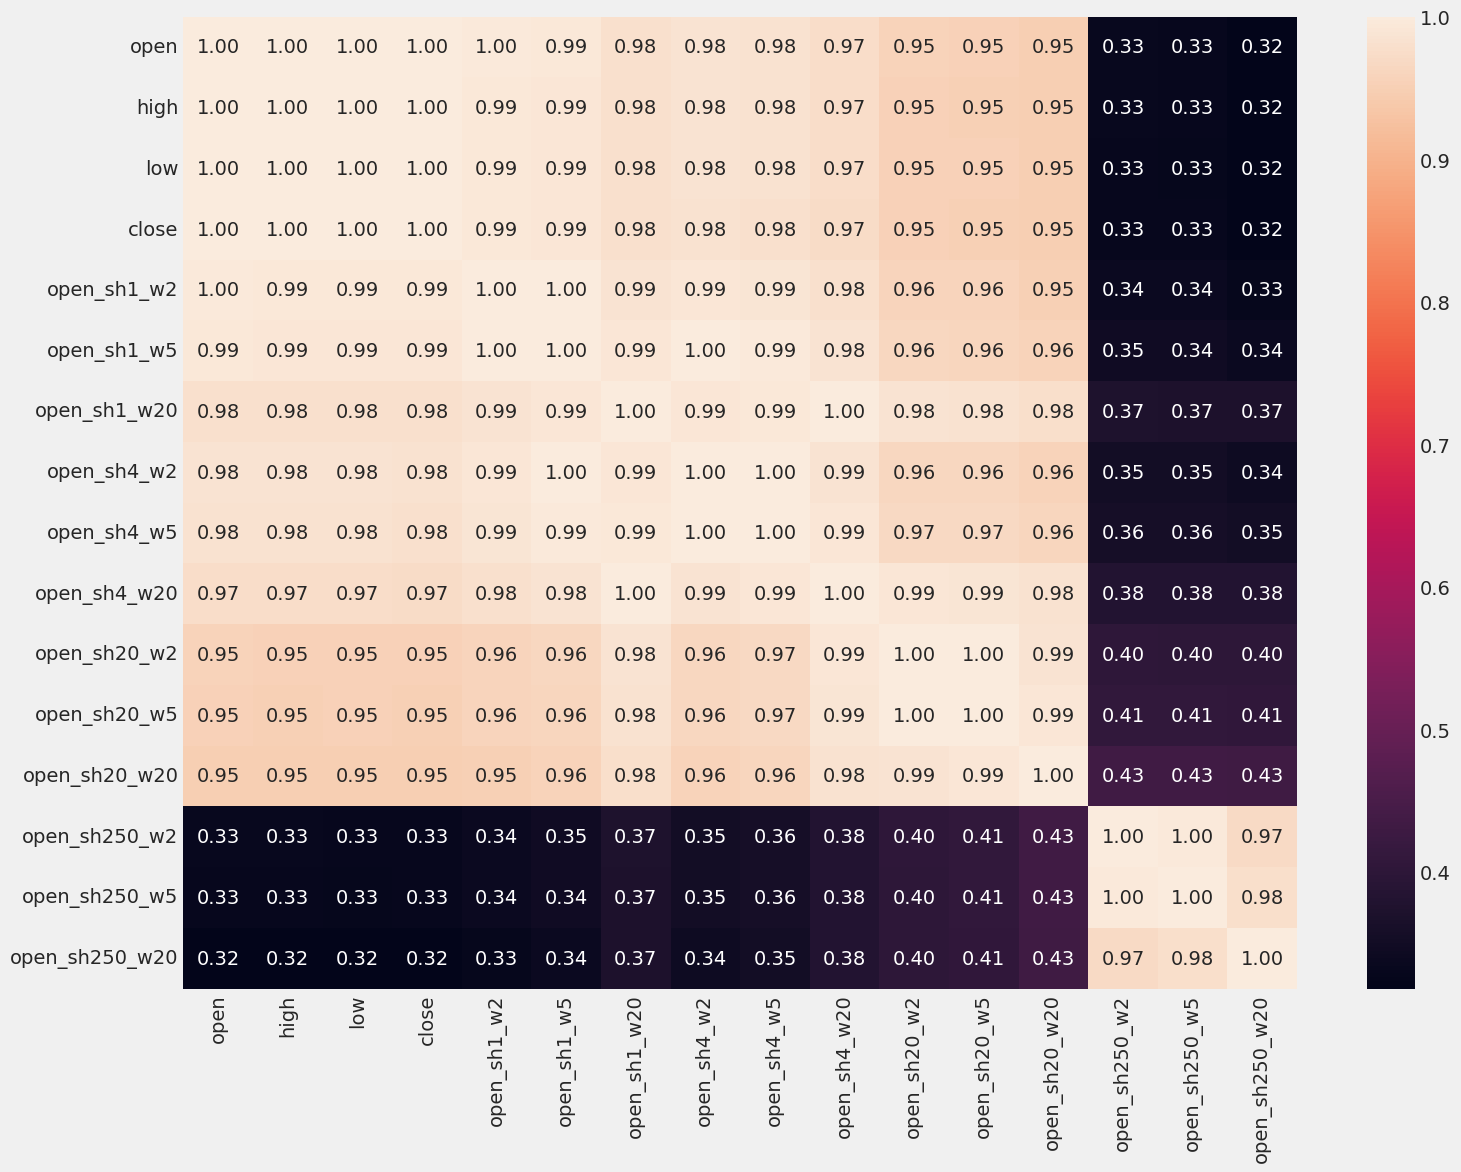

In [44]:
f, ax = plt.subplots(figsize=(16, 12))
corr = data.drop(['volume', 'timestamp'], axis=1).tail(600).corr()
sns.heatmap(corr, annot=True, fmt=".2f")

## Период - 1 год


In [50]:
data.tail(240).timestamp.min(), data.tail(240).timestamp.max(),


('2022-11-29', '2023-11-10')

<Axes: >

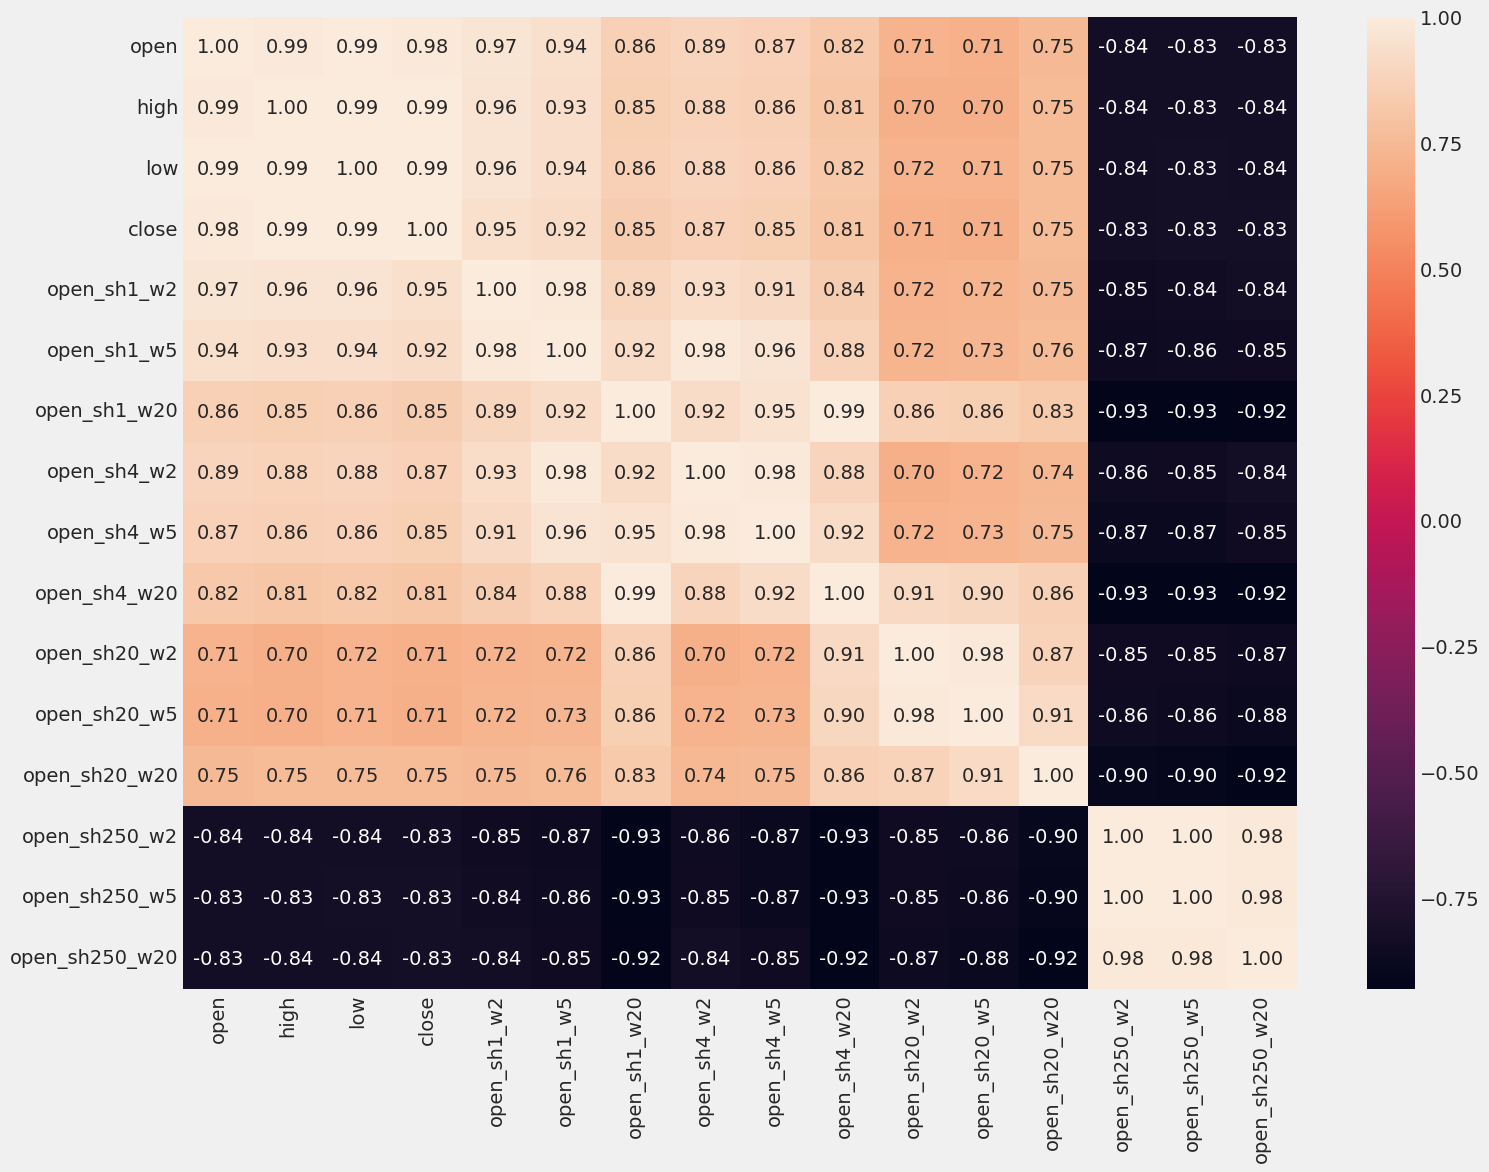

In [46]:
f, ax = plt.subplots(figsize=(16, 12))
corr = data.drop(['volume', 'timestamp'], axis=1).tail(240).corr()
sns.heatmap(corr, annot=True, fmt=".2f")

## Период - 2,5 месяца


In [51]:
data.tail(60).timestamp.min(), data.tail(60).timestamp.max(),


('2023-08-18', '2023-11-10')

<Axes: >

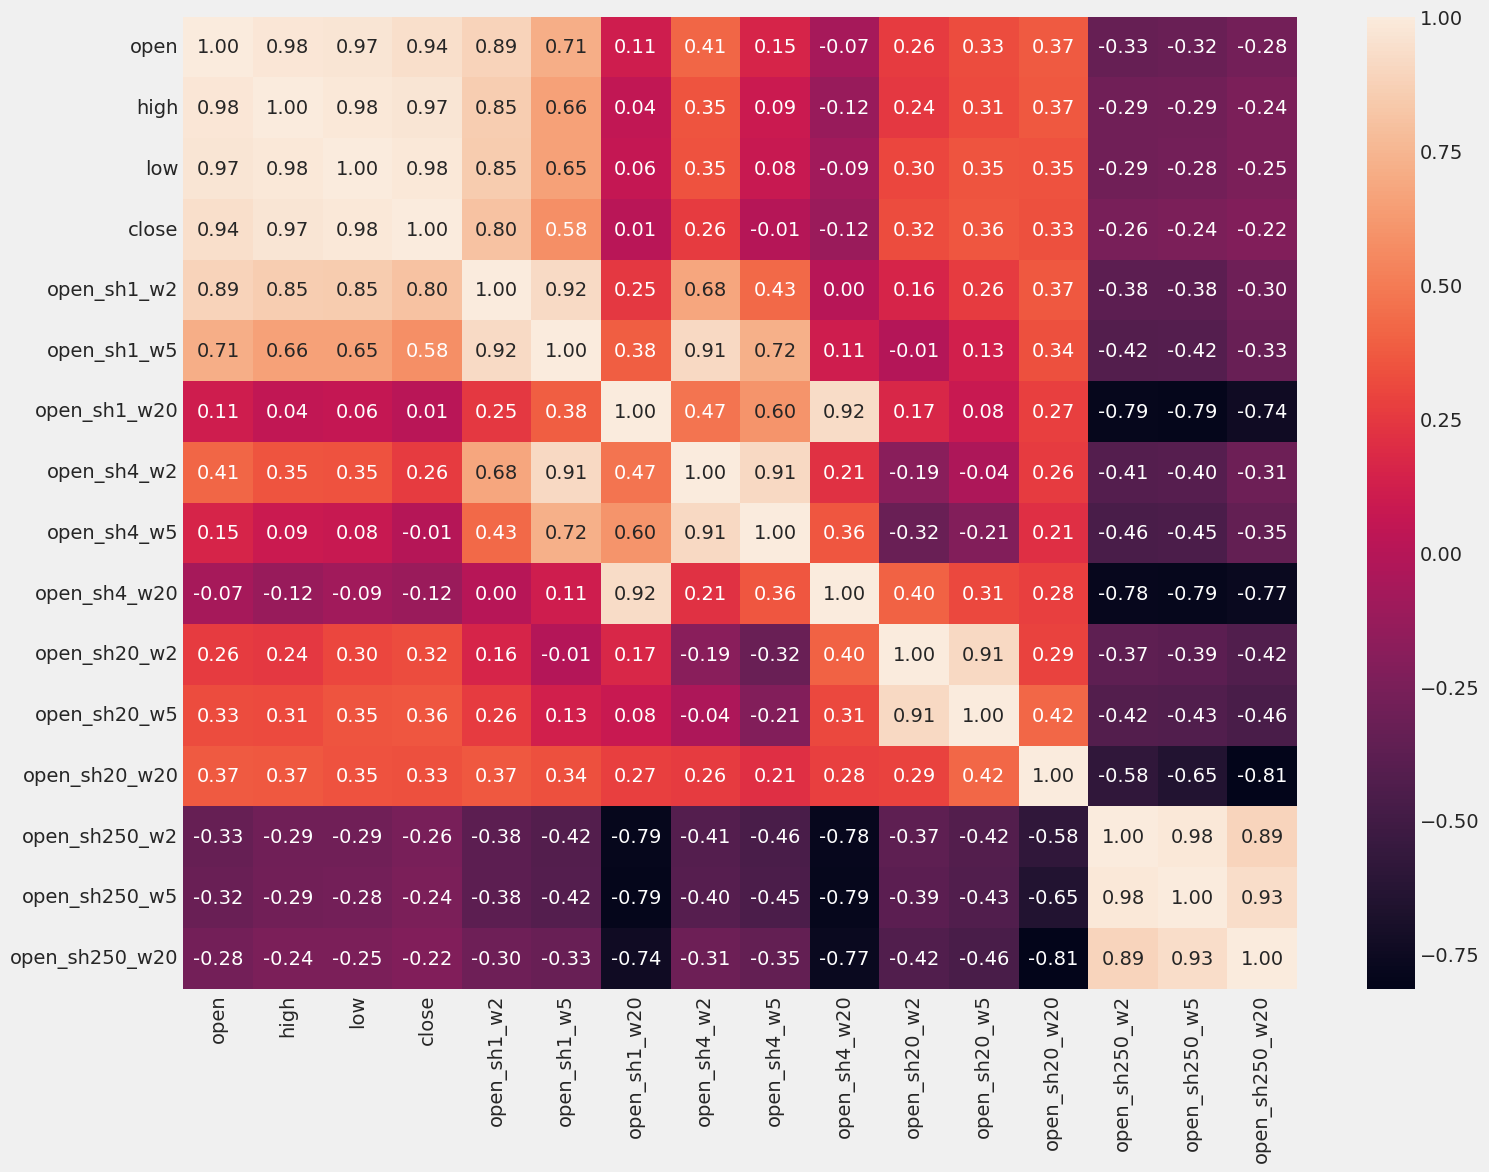

In [45]:
f, ax = plt.subplots(figsize=(16, 12))
corr = data.drop(['volume', 'timestamp'], axis=1).tail(60).corr()
sns.heatmap(corr, annot=True, fmt=".2f")

## Выводы

Для прогнозирования направления движения цены лаговые фичи с окном 2, 5 и сдвигом на 2, 4 точки могут быть значимыми фичами или базовой моделью (судя по корреляции).

При этом стоит обратить внимание, что чем больше рассматриваемый период, тем больше корреляция. Так на периоде в 2,5 месяца разброс корреляции сильный -0.07:0.89, а при увеличении периода диапазон смещается к 0.9-1.0.
Это может означать, что последние несколько месяцев поведение было нетипычным, что может быть связано с особым периодом (публикация отчетности, изменение ставки ФРС и тд).

При использовании базовой модели в таком формате детектировать возникновение таких периодов (к примеру если качество модели снизилось в последние N точек) и не опираться на такую модель до окончания нестабильности.

---



## Зависимость цены закрытия от цены открытия

In [53]:
data['flag_open_rise'] = (data['open'] > data.open_sh1_w2).astype(int)
data['flag_close_rise'] = (data.close > data.close.shift(1).rolling(2).mean()).astype(int)

In [69]:
for p in [6000, 600, 240, 60]:
    tmp = data.tail(p)
    print('-'*100)
    for val in data['flag_open_rise'].unique():
        ind = (tmp['flag_open_rise'] == val)
        print(f'Рассматриваемый период: {pd.to_datetime(tmp.timestamp.max()) - pd.to_datetime(tmp.timestamp.min())};')
        print(f'Период: Цена open возросла: {val};')
        print(f'Доля случаев, где цена закрытия возросла: {round(tmp[ind].flag_close_rise.mean(), 2)};\n')

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 8708 days 00:00:00;
Период: Цена open возросла: 0;
Доля случаев, где цена закрытия возросла: 0.33;

Рассматриваемый период: 8708 days 00:00:00;
Период: Цена open возросла: 1;
Доля случаев, где цена закрытия возросла: 0.69;

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 868 days 00:00:00;
Период: Цена open возросла: 0;
Доля случаев, где цена закрытия возросла: 0.29;

Рассматриваемый период: 868 days 00:00:00;
Период: Цена open возросла: 1;
Доля случаев, где цена закрытия возросла: 0.72;

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 346 days 00:00:00;
Период: Цена open возросла: 0;
Доля случаев, где цена закрытия возросла: 0.31;

Рассматриваемый период: 346 days 00:00:00;
Период: Цена open возросла: 1;
Доля с

## Вывод
В большинстве случаев при увеличении цены открытия, цена закрытия также увеличивается. Это прослеживается вплоть до горизонта в 23 года, хотя доля таких случаев уменьшается с увеличением периода. Это говорит о том, что в разные временные отрезки колебания стоимости могут быть разной величины и частоты. Но закономерность прослеживается, что можно использовать как фичу для модели.

Стоит заметить, что величина, на которую меняется цена может играть тут важную роль. Если в случаях, где рост не совпадает, изменение цены больше чем в тех, где совпадает и мы никак не сможем это задетектить, то это отрицательно скажется на работе торгового бота - модели.

## Анализ отклонений

Проанализируем насколько процентов отклоняется значение цены open/close от лаговой фичи.

In [72]:
data['coef_open'] = data.open / data.open_sh1_w2
data['coef_close'] = data.close / data.close.shift(1).rolling(2).mean()

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 8708 days 00:00:00;


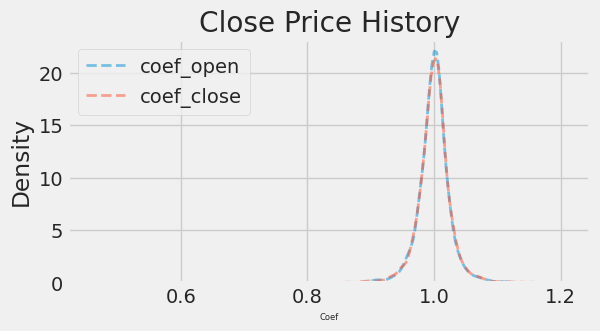

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 868 days 00:00:00;


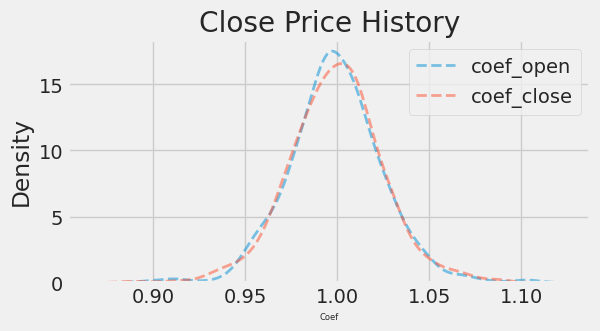

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 346 days 00:00:00;


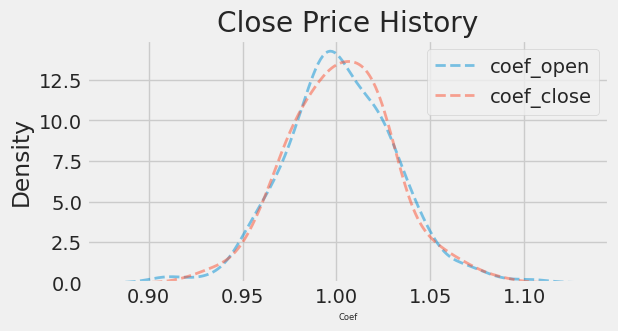

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 84 days 00:00:00;


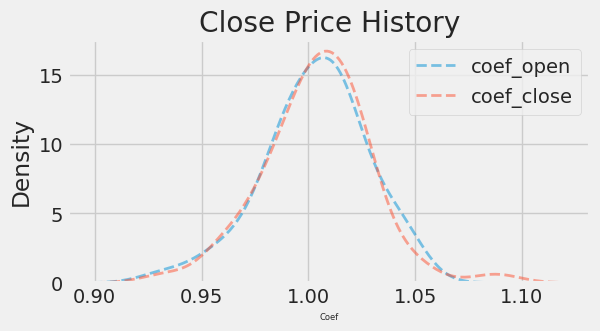

In [88]:
for p in [6000, 600, 240, 60]:
    tmp = data.tail(p)
    print('-'*100)
    print(f'Рассматриваемый период: {pd.to_datetime(tmp.timestamp.max()) - pd.to_datetime(tmp.timestamp.min())};')
    # print(tmp[['coef_open', 'coef_close']].describe())
    f, ax = plt.subplots(figsize=(6, 3))
    sns.kdeplot(data=tmp, x="coef_open", alpha=0.5, label='coef_open', linestyle='--', linewidth=2)
    sns.kdeplot(data=tmp, x="coef_close", alpha=0.5, label='coef_close', linestyle='--', linewidth=2)
    plt.title('Close Price History')
    plt.legend()
    plt.xlabel('Coef', fontsize=6)
    # plt.ylabel('Price', fontsize=6)
    plt.show()

## Вывод

Распределение выглядит как нормальное, что является хорошим свойством для использования линейной регрессии, если мы будем предсказывать отклонение в процентах или схожий таргет.


Проверим отношение цены закрытия к цене открытия в случаях, когда цена открытия растет.

In [96]:
data['coef_close_open'] = data['close'] / data['open']

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 8708 days 00:00:00;
0.9998375860690266


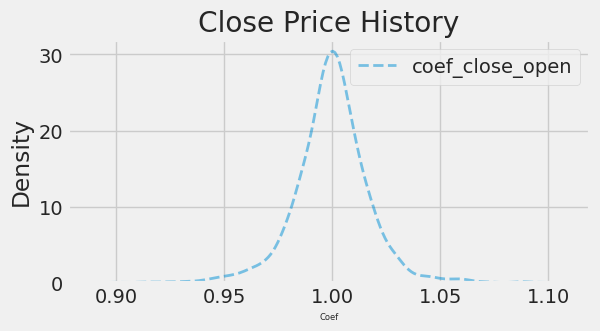

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 868 days 00:00:00;
1.001500028011595


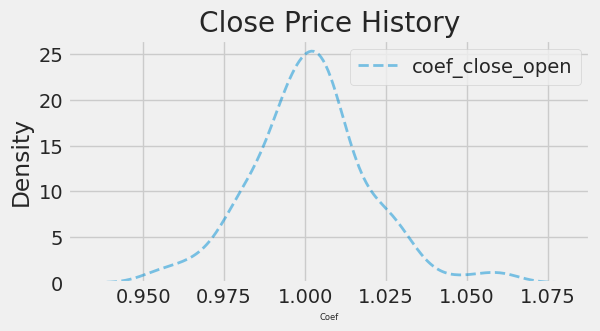

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 346 days 00:00:00;
1.0034813327805663


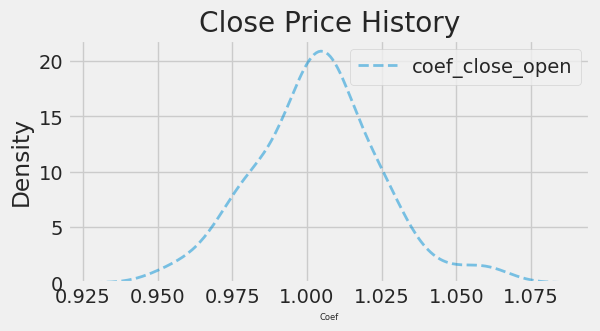

----------------------------------------------------------------------------------------------------
Рассматриваемый период: 84 days 00:00:00;
1.0018762166975856


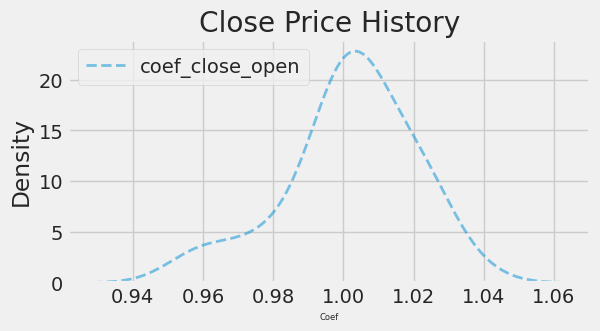

In [99]:
for p in [6000, 600, 240, 60]:
    tmp = data.tail(p)
    print('-'*100)
    print(f'Рассматриваемый период: {pd.to_datetime(tmp.timestamp.max()) - pd.to_datetime(tmp.timestamp.min())};')
    ind = (tmp.flag_open_rise == 1)
    print(tmp[ind].coef_close_open.mean())

    f, ax = plt.subplots(figsize=(6, 3))
    sns.kdeplot(data=tmp[ind], x="coef_close_open", alpha=0.5, label='coef_close_open', linestyle='--', linewidth=2)
    plt.title('Close Price History')
    plt.legend()
    plt.xlabel('Coef', fontsize=6)
    plt.show()

## Вывод

Распределение очень близко к нормальному.
Смещение в большую сторону очень мало и в среднем составляет доли процентов.
То есть использование значения цены открытия и его отношения к лаговой фиче вряд ли позволит создать прибыльную модель с учетом потерь при ошибках.

# Общие выводы

После короткого анализа можно заключить, что можно использовать лаговые фичи в качестве бэйзлана или признаков модели.

При увеличении цены открытие относительно предыдущего дня в большинстве случаев увеличивается и цена закрытия, эту особенность можно использовать при создании фичей и каких-то особенностей модели (возможно эмпирических правил, применяющихся к финальному прогнозу).

Также мы обнаружили, что при увеличении цены открытия относительно предыдущих значений, цена закрытия относительно цены открытия в среднем увеличивается незначимо. Значит, чтобы использовать коэф-т для цены открытия для предсказания цены закрытия необходимы доработки.